In [18]:
import pandas as pd

from cleaning import import_merge, preprocess, remove_stopwords
from main import undersample_split_vectorise, oversample, split, log_model, forest_model, oversample_2, grad_model

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

### Importing and Cleaning

In [2]:
df = import_merge()
df = preprocess(df)
df = remove_stopwords(df)

In [3]:
df.head(5)

,review_score,no_stop_words
0,4,testei produto ainda veio correto boas condiçõ...
1,4,bom produto
3,5,produto exatamente esperava descrito site cheg...
9,1,aguardando retorno loja
13,4,gostei produto


In [4]:
X_train_und, X_test_und, y_train_und, y_test_und = undersample_split_vectorise(df)
X_train_over, X_test_over, y_train_over, y_test_over = oversample_2(df)
X_train, X_test, y_train, y_test = split(df)

### Modelling

Logistic Regression, Random Forest and Gradient Boost will be used for the modelling. 3 models of each algorithm will be used: undersampling, oversampling and the dataset unchanged.



### Logistic Regression

In [5]:
acc_score_log_norm, report_log_norm, matrix_log_norm = log_model(X_train, X_test, y_train, y_test)
acc_score_log_und, report_log_und, matrix_log_und = log_model(X_train_und, X_test_und, y_train_und, y_test_und)
acc_score_log_over, report_log_over, matrix_log_over = log_model(X_train_over, X_test_over, y_train_over, y_test_over)

In [6]:
print(acc_score_log_norm, acc_score_log_und, acc_score_log_over)

0.3493900138347378 0.21097372488408037 0.2846182870079235


In [21]:
print(report_log_over)

              precision    recall  f1-score   support

           1       0.24      0.30      0.27      1510
           2       0.06      0.15      0.08       406
           3       0.11      0.11      0.11       711
           4       0.14      0.20      0.17      1185
           5       0.56      0.35      0.43      4139

    accuracy                           0.28      7951
   macro avg       0.22      0.22      0.21      7951
weighted avg       0.37      0.28      0.31      7951



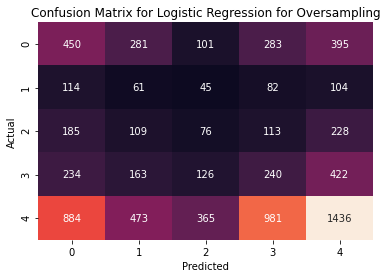

In [23]:
sns.heatmap(matrix_log_over, annot=True, fmt='g', vmin=0, cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression for Oversampling")
plt.show()

In [26]:
y_test.value_counts(normalize=True)

5    0.516161
1    0.191045
4    0.149918
3    0.089548
2    0.053327
Name: review_score, dtype: float64

The accuracy scores aren't a great indicator for the results here because the normal dataset is very imbalanced towards 5 stars reviews. As above exploring the y_test data, if the model predicted only 5 stars it would perform at around 51% accuracy. The undersampling and oversampling have balanced data and stratify was used when spliting the data. The accuracy was poor for both, around 21% for undersampling and 28% for oversampling.

### Random Forest

In [8]:
acc_score_forest_norm, report_forest_norm, matrix_forest_norm = forest_model(X_train, X_test, y_train, y_test)
acc_score_forest_und, report_forest_und, matrix_forest_und = forest_model(X_train_und, X_test_und, y_train_und, y_test_und)
acc_score_forest_over, report_forest_over, matrix_forest_over = forest_model(X_train_over, X_test_over, y_train_over, y_test_over)

In [9]:
print(acc_score_forest_norm, acc_score_forest_und, acc_score_forest_over)

0.3755502452521695 0.241112828438949 0.27153817129920765


Random Forest didn't managed to improve on the logistic regression models. It performed slightly better in the undersampled data but around 1% worse in the oversampled.

### Gradient Boost

In [10]:
acc_score_grad_norm, report_grad_norm, matrix_grad_norm = grad_model(X_train, X_test, y_train, y_test)
acc_score_grad_und, report_grad_und, matrix_grad_und = grad_model(X_train_und, X_test_und, y_train_und, y_test_und)
acc_score_grad_over, report_grad_over, matrix_grad_over = grad_model(X_train_over, X_test_over, y_train_over, y_test_over)

In [11]:
print(acc_score_grad_norm, acc_score_grad_und, acc_score_grad_over)

0.5131430008803924 0.1982225656877898 0.10401207395296189


Gradient Boost also failed to improve on the undersampled and oversampled data. The normal data appears to be the best with 51% but as explored earlier, we could get this results from only estimating 5 star review.

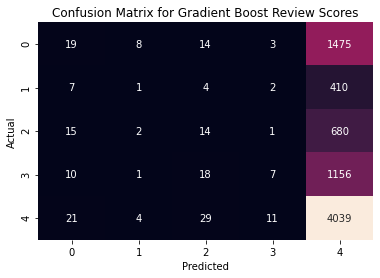

In [20]:
sns.heatmap(matrix_grad_norm, annot=True, fmt='g', vmin=0, cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Gradient Boost Review Scores")
plt.show()

### GridSearch for Normal Data using Gradient Boost

In [12]:
clf = GridSearchCV(GradientBoostingClassifier(), 
                          { "max_features":[1000,2000,2500,3000]},
                  cv=5, return_train_score=False)

In [13]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_features': [1000, 2000, 2500, 3000]})

In [14]:
clf.best_score_

0.6300232845790831

In [17]:
df_clf = pd.DataFrame(clf.cv_results_)
df_clf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.158200,0.373426,0.061441,0.002924,1000,{'max_features': 1000},0.629304,0.630090,0.627201,0.630975,0.630503,0.629614,0.001326,4
1,9.214725,0.516238,0.063786,0.004664,2000,{'max_features': 2000},0.628518,0.631976,0.629560,0.631132,0.628931,0.630023,0.001320,2
2,9.896077,0.364320,0.059548,0.001230,2500,{'max_features': 2500},0.629932,0.630876,0.627987,0.629403,0.631761,0.629992,0.001287,3
3,10.479407,0.090300,0.059336,0.001020,3000,{'max_features': 3000},0.628518,0.631033,0.627987,0.631761,0.630818,0.630023,0.001489,1


In [29]:
clf_under = GridSearchCV(GradientBoostingClassifier(), 
                          { "max_features":[1000,2000,2500,3000]},
                  cv=5, return_train_score=False)

In [32]:
clf_under.fit(X_train_und, y_train_und)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_features': [1000, 2000, 2500, 3000]})

In [33]:
clf_under.best_score_

0.4259767023206618